In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from graphviz import Digraph
import scipy.spatial.distance
from scipy.cluster.hierarchy import dendrogram
#Clustering birch
from freediscovery.cluster import birch_hierarchy_wrapper
from freediscovery.cluster import Birch,BirchSubcluster
#Sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn import metrics
#Learners
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
#Distance measure
from scipy.spatial.distance import euclidean

import warnings

import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

In [3]:
class bcluster(object):
    
    def __init__(self):
        self.parent = None
        self.parent_id = None
        self.depth = None
        self.size = None
        self.cluster_id = None
        self.data_points = []
        self.test_points = []
        self.test_labels = []
        self.predicted = []
        self.centroid = None
        self.classifier = None
        self.outlier_model = None
        self.cluster_obj = None
        self.outlier_points = []
        self.score = []
        self.d1 = None
        self.d2 = None
        self.threshold = None
    
    def set_parent(self,parent_node=None):
        if parent_node == None:
            self.parent = None
            self.parent_id = None
        else:
            self.parent = parent_node
            self.parent_id = parent_node.cluster_id
    
    def set_depth(self,depth):
        self.depth = depth
    
    def set_size(self,size):
        self.size = size
        
    def set_cluster_id(self,cluster_id):
        self.cluster_id = cluster_id
        
    def set_data_points(self,data_points):
        self.data_points = data_points
    
    def set_test_labels(self,test_labels):
        self.test_labels = test_labels
        
    def add_test_points(self,test_point):
        self.test_points.append(test_point)
        
    def add_predicted(self,predicted):
        self.predicted.append(predicted)
    
    def set_centroid(self,centroid):
        self.centroid = centroid
        
    def set_classifier(self,classifier):
        self.classifier = classifier
        
    def set_outlier_model(self,outlier_model):
        self.outlier_model = outlier_model
        
    def set_cluster_obj(self,cluster_obj):
        self.cluster_obj = cluster_obj
        
    def add_outlier_points(self,outlier_points):
        self.outlier_points.append(outlier_points)
        
    def set_score(self,score):
        self.score = score
        
    def add_d1(self,d1):
        self.d1 = d1
        
    def add_d2(self,d2):
        self.d2 = d2
        
    def calculate_threshold(self,outlier_threshold):
        self.threshold = max(self.d1,self.d2)*outlier_threshold
        
    def check_outlier(self,distance):
        if self.threshold < distance:
            result = True
        else:
            result = False
        return result

In [4]:
class birch(object):

    def __init__(self,threshold=0.7,branching_factor=20,n_clusters=None,outlier_threshold=0.5):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.n_clusters = n_clusters
        self.outlier_threshold = outlier_threshold
        self.Birch_clusterer = Birch(threshold=self.threshold, branching_factor=self.branching_factor,
                                     n_clusters=self.n_clusters,compute_sample_indices=True)
    # Fitting the model with train_X
    def fit(self,data,y):
        self.data = data
        self.y = y
        #self.data.drop(self.data.columns[len(self.data.columns)-1], axis=1, inplace=True)
        self.Birch_clusterer.fit(self.data)

    #Defines and builds the Cluster Feature Tree
    def get_cluster_tree(self):
        self.htree, n_clusters = birch_hierarchy_wrapper(self.Birch_clusterer)
        clusters = {}
        max_depth = 0
        for i in range(n_clusters):
            node = bcluster()
            sub_cluster = self.htree.flatten()[i]
            node.set_cluster_id(sub_cluster['cluster_id'])
            depth = sub_cluster.current_depth
            node.set_depth(depth)
            if depth > max_depth:
                max_depth = depth
            if i not in clusters.keys():
                clusters[i] = {}
            if sub_cluster.current_depth == 0:
                node.set_parent()
            else:
                node.set_parent(clusters[sub_cluster.parent['cluster_id']])
            cluster_size = sub_cluster['cluster_size']
            node.set_size(cluster_size)
            data_points = sub_cluster['document_id_accumulated']
            node.set_data_points(data_points)
            centroid = self.data.iloc[sub_cluster['document_id_accumulated'], :].mean(axis=0).values
            node.set_centroid(centroid)
            d1,d1_v = self.calculate_d1(centroid,data_points)
            d2 = self.calculate_d2(centroid,data_points,d1_v)
            node.add_d1(d1)
            node.add_d2(d2)
            node.calculate_threshold(self.outlier_threshold)
            clusters[i] = node
        return clusters,max_depth
    
    #Calculate the d1 distance(point farthest away from centroid)
    def calculate_d1(self,centroid,data_points):
        d1 = 0
        u = centroid
        d1_v = None
        for point in data_points:
            v = point
            distance = euclidean(u,v)
            if distance>d1:
                d1 = distance
                d1_v = v
        return d1,d1_v
    
    #Calculate the d2 distance(point farthest away from d1 and its distance from centroid)
    def calculate_d2(self,centroid,data_points,d1_v):
        d2_d1 = 0
        u = d1_v
        d2_v = None
        for point in data_points:
            v = point
            distance = euclidean(u,v)
            if distance>d2_d1:
                d2_d1 = distance
                d2_v = v
        d2 = euclidean(centroid,v)
        return d2
    
    # Display's the tree
    def show_clutser_tree(self):
        self.htree.display_tree()
        
    # Add classification model at each node and leaf
    def model_adder(self,cluster_tree):
        for cluster_id in cluster_tree:
            clf = DecisionTreeClassifier(criterion='entropy')
            sample_points = cluster_tree[cluster_id].data_points
            train_X_sub = self.data.iloc[sample_points,:]
            train_y_sub = self.y.iloc[sample_points]
            clf.fit(train_X_sub,train_y_sub)
            cluster_tree[cluster_id].set_classifier(clf)
        return cluster_tree
        
    # Prediction Function with height based prediction with outlier detection
    def predict(self,test_X,depth):
        predicted = []
        for test_instance in test_X.iterrows():
            test_sample = test_instance[1].values
            min_distance = float('inf')
            selected_cluster = None
            for cluster_id in cluster_tree:
                if cluster_tree[cluster_id].depth != depth:
                    continue
                u = cluster_tree[cluster_id].centroid
                v = np.asarray(test_sample,dtype='float64')
                distance = euclidean(u,v)
                if distance < min_distance:
                    min_distance = distance
                    selected_cluster = cluster_id
            cluster_tree[selected_cluster].add_test_points(test_instance[0])
            # Outlier identifier
            if cluster_tree[selected_cluster].check_outlier(min_distance):
                cluster_tree[selected_cluster].add_outlier_points(test_instance[0])
            _predicted_label = cluster_tree[selected_cluster].classifier.predict([test_sample])
            cluster_tree[selected_cluster].add_predicted(_predicted_label)
            predicted.append(_predicted_label)
        return predicted
    
    # Model certification creator
    def certify_model(self,cluster_tree,test_y):
        for cluster_id in cluster_tree:
            if len(cluster_tree[cluster_id].test_points) == 0:
                continue
            cluster_tree[cluster_id].set_test_labels(test_y[cluster_tree[cluster_id].test_points].values)
            precision = metrics.precision_score(cluster_tree[cluster_id].test_labels, 
                                                cluster_tree[cluster_id].predicted,average='weighted')
            recall = metrics.recall_score(cluster_tree[cluster_id].test_labels, 
                                          cluster_tree[cluster_id].predicted,average='weighted')
            f1_Score = metrics.f1_score(cluster_tree[cluster_id].test_labels, 
                                        cluster_tree[cluster_id].predicted,average='weighted')
            score = {'precision': precision,'recall': recall,'f1_Score': f1_Score}
            cluster_tree[cluster_id].set_score(score)

In [5]:
def load_data(path,target):
    df = pd.read_csv(path)
    if path == 'data/jm1.csv':
        df = df[~df.uniq_Op.str.contains("\?")]
    y = df[target]
    X = df.drop(labels = target, axis = 1)
    X = X.apply(pd.to_numeric)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
    return train_X, test_X, train_y, test_y

def load_mutated_data(path,target):
    train_X, test_X, train_y, test_y = load_data(path,target)
    test_X = pd.concat([train_X,test_X])
    test_y = pd.concat([train_y,test_y])
    return test_X,test_y

In [16]:
# Cluster Driver
def cluster_driver(file,print_tree = True):
    train_X, test_X, train_y, test_y = load_data(file,'defects')
    cluster = birch(branching_factor=5)
    cluster.fit(train_X,train_y)
    cluster_tree,max_depth = cluster.get_cluster_tree()
    cluster_tree = cluster.model_adder(cluster_tree)
    if print_tree:
        cluster.show_clutser_tree()
    return cluster,cluster_tree,max_depth

In [17]:
# getting the cluster tree
file = 'data/jm1.csv'
cluster,cluster_tree,max_depth = cluster_driver(file)

[cluster_id=0] N_children: 4 N_samples: 50
> [cluster_id=1] N_children: 3 N_samples: 13
> > [cluster_id=2] N_children: 0 N_samples: 5
> > [cluster_id=3] N_children: 0 N_samples: 5
> > [cluster_id=4] N_children: 0 N_samples: 3
> [cluster_id=5] N_children: 3 N_samples: 12
> > [cluster_id=6] N_children: 0 N_samples: 5
> > [cluster_id=7] N_children: 0 N_samples: 4
> > [cluster_id=8] N_children: 0 N_samples: 3
> [cluster_id=9] N_children: 4 N_samples: 15
> > [cluster_id=10] N_children: 0 N_samples: 3
> > [cluster_id=11] N_children: 0 N_samples: 4
> > [cluster_id=12] N_children: 0 N_samples: 5
> > [cluster_id=13] N_children: 0 N_samples: 3
> [cluster_id=14] N_children: 3 N_samples: 10
> > [cluster_id=15] N_children: 0 N_samples: 3
> > [cluster_id=16] N_children: 0 N_samples: 4
> > [cluster_id=17] N_children: 0 N_samples: 3


In [8]:
# Base performance score
clf = DecisionTreeClassifier(criterion='entropy')
train_X, test_X, train_y, test_y = load_data(file,'defects')
clf.fit(train_X, train_y)
predicted = clf.predict(test_X)
print(metrics.classification_report(test_y, predicted))

              precision    recall  f1-score   support

       False       0.84      0.85      0.85      2885
        True       0.37      0.35      0.36       706

   micro avg       0.75      0.75      0.75      3591
   macro avg       0.60      0.60      0.60      3591
weighted avg       0.75      0.75      0.75      3591



In [9]:
# Birch classifier score(mention depth)
file = 'data/jm1_15.csv'
test_X,test_y = load_mutated_data(file,'defects')
depth = max_depth
predicted = cluster.predict(test_X,depth)
print(metrics.classification_report(test_y, predicted))
cluster.certify_model(cluster_tree,test_y)

              precision    recall  f1-score   support

       False       0.83      0.80      0.82      2964
        True       0.19      0.22      0.20       627

   micro avg       0.70      0.70      0.70      3591
   macro avg       0.51      0.51      0.51      3591
weighted avg       0.72      0.70      0.71      3591



In [10]:
for i in cluster_tree:
    if len(cluster_tree[i].test_points) == 0:
        continue
    print(cluster_tree[i].score)

{'precision': 0.4444444444444444, 'recall': 0.6666666666666666, 'f1_Score': 0.5333333333333333}
{'precision': 0.8784313725490196, 'recall': 0.8235294117647058, 'f1_Score': 0.8500948766603416}
{'precision': 0.0, 'recall': 0.0, 'f1_Score': 0.0}
{'precision': 0.0, 'recall': 0.0, 'f1_Score': 0.0}
{'precision': 1.0, 'recall': 0.8333333333333334, 'f1_Score': 0.9090909090909091}
{'precision': 1.0, 'recall': 0.5, 'f1_Score': 0.6666666666666666}
{'precision': 0.6694214876033059, 'recall': 0.8181818181818182, 'f1_Score': 0.7363636363636363}
{'precision': 0.027777777777777776, 'recall': 0.16666666666666666, 'f1_Score': 0.047619047619047616}
{'precision': 0.40625, 'recall': 0.3125, 'f1_Score': 0.3259803921568627}
{'precision': 1.0, 'recall': 1.0, 'f1_Score': 1.0}
{'precision': 0.0, 'recall': 0.0, 'f1_Score': 0.0}
{'precision': 0.9249999999999999, 'recall': 0.25, 'f1_Score': 0.29720279720279724}
{'precision': 0.6593137254901961, 'recall': 0.20588235294117646, 'f1_Score': 0.18869365928189458}
{'prec

In [220]:
total = 0
for i in cluster_tree:
    if len(cluster_tree[i].test_points) == 0:
        continue
    total += len(cluster_tree[i].outlier_points)
total

3323

In [11]:
num_outliers = []
for i in range(20):
    s_file = 'data/JDT.csv'
    cluster,cluster_tree,max_depth = cluster_driver(s_file)
    t_file = 'data/JDT_' + str(i) +'.csv'
    test_X,test_y = load_mutated_data(t_file,'defects')
    depth = max_depth
    predicted = cluster.predict(test_X,depth)
    cluster.certify_model(cluster_tree,test_y)
    total = 0
    for i in cluster_tree:
        if len(cluster_tree[i].test_points) == 0:
            continue
        total += len(cluster_tree[i].outlier_points)
    num_outliers.append(total/test_X.shape[0])

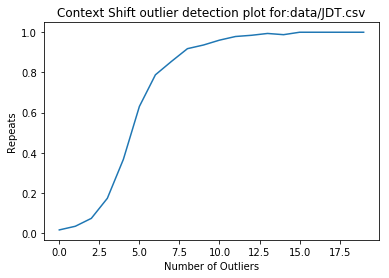

In [12]:
plt.plot(num_outliers)
plt.title('Context Shift outlier detection plot for:' + s_file)
plt.xlabel('Number of Outliers')
plt.ylabel('Repeats')
plt.show()